In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
# from sklearn.manifold import TSNE
# import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns

from alignment import TrivialAlignment, CCA, ManifoldLinear, manifold_nonlinear
from correspondence import Correspondence
from distance import SquaredL2
from neighborhood import neighbor_graph
from util import pairwise_error, Timer
# from viz import show_alignment
from warping import manifold_warping_linear

from rpy2.robjects import r
import rpy2.robjects.pandas2ri as pandas2ri

In [2]:
# file = "../../data/expr.RData"
# rf = r['load'](file)

# dayExpr = pandas2ri.ri2py_dataframe(r['dayExpr'])
# nightExpr = pandas2ri.ri2py_dataframe(r['nightExpr'])

# X = dayExpr.as_matrix()
# Y = nightExpr.as_matrix()

In [12]:
X = pd.read_csv("./../../../mynotebooks/home/cc/MyNotebooks/A549/A549_processed_atac_data_1000_loci.csv")
X.index = X["Unnamed: 0_x"]
X = X.drop(["Unnamed: 0_x"], axis=1)
X = X.T
X

Unnamed: 0_x              GL000195.1-30585-33269  GL000205.1-84750-87026  \
sci_RNA_A_001_TCTCTCATCC                2.846214                0.000000   
sci_RNA_A_001_GACCAATGCG                2.144959                0.000000   
sci_RNA_A_002_ATCTAGGTTC                0.000000                0.000000   
sci_RNA_A_003_ACGTTGAATG                2.762527                0.000000   
sci_RNA_A_003_CCTAAGCGGT                3.357246                0.000000   
...                                          ...                     ...   
sci_RNA_E_095_ACGATAGACT                0.000000                2.388522   
sci_RNA_E_096_TGCCTAACTT                3.000337                3.000337   
sci_RNA_E_096_GGCGGTTGAC                2.462230                1.738487   
sci_RNA_E_096_CGAATCTCCT                2.081225                0.000000   
sci_RNA_E_096_ATATGCCATC                3.986407                0.000000   

Unnamed: 0_x              11-65265876-65267383  17-19641246-19641866  \
sci_RNA_A_001_TCTCTCATCC              0.000000              0.000000   
sci_RNA_A_001_GACCAATGCG              0.000000              0.000000   
sci_RNA_A_002_ATCTAGGTTC              0.000000              0.000000   
sci_RNA_A_003_ACGTTGAATG              0.000000              0.000000   
sci_RNA_A_003_CCTAAGCGGT              0.000000              2.605544   
...                                        ...                   ...   
sci_RNA_E_095_ACGATAGACT              0.000000              0.000000   
sci_RNA_E_096_TGCCTAACTT              3.000337              0.000000   
sci_RNA_E_096_GGCGGTTGAC              0.000000              0.000000   
sci_RNA_E_096_CGAATCTCCT              2.081225              0.000000   
sci_RNA_E_096_ATATGCCATC              0.000000              0.000000   

Unnamed: 0_x              hs37d5-10060723-10061824  12-52679637-52680369  \
sci_RNA_A_001_TCTCTCATCC                  0.000000                   0.0   
sci_RNA_A_001_GACCAATGCG                  0.000000                   0.0   
sci_RNA_A_002_ATCTAGGTTC                  0.000000                   0.0   
sci_RNA_A_003_ACGTTGAATG                  0.000000                   0.0   
sci_RNA_A_003_CCTAAGCGGT                  0.000000                   0.0   
...                                            ...                   ...   
sci_RNA_E_095_ACGATAGACT                  2.388522                   0.0   
sci_RNA_E_096_TGCCTAACTT                  0.000000                   0.0   
sci_RNA_E_096_GGCGGTTGAC                  1.738487                   0.0   
sci_RNA_E_096_CGAATCTCCT                  0.000000                   0.0   
sci_RNA_E_096_ATATGCCATC                  3.228211                   0.0   

Unnamed: 0_x              GL000220.1-126751-128655  hs37d5-6743365-6744013  \
sci_RNA_A_001_TCTCTCATCC                  0.000000                0.000000   
sci_RNA_A_001_GACCAATGCG                  2.144959                0.000000   
sci_RNA_A_002_ATCTAGGTTC                  0.000000                3.207165   
sci_RNA_A_003_ACGTTGAATG                  0.000000                0.000000   
sci_RNA_A_003_CCTAAGCGGT                  0.000000                0.000000   
...                                            ...                     ...   
sci_RNA_E_095_ACGATAGACT                  0.000000                0.000000   
sci_RNA_E_096_TGCCTAACTT                  0.000000                0.000000   
sci_RNA_E_096_GGCGGTTGAC                  0.000000                0.000000   
sci_RNA_E_096_CGAATCTCCT                  0.000000                0.000000   
sci_RNA_E_096_ATATGCCATC                  0.000000                0.000000   

Unnamed: 0_x              12-6646739-6648036  15-60689229-60691441  ...  \
sci_RNA_A_001_TCTCTCATCC                 0.0              0.000000  ...   
sci_RNA_A_001_GACCAATGCG                 0.0              0.000000  ...   
sci_RNA_A_002_ATCTAGGTTC                 0.0              0.000000  ...   
sci_RNA_A_003_ACGTTGAATG                 0.0              0.000000  ... 

In [13]:
Y = pd.read_csv("./../../../mynotebooks/home/cc/MyNotebooks/A549/A549_processed_rna_data_600_genes.csv")
Y.index = Y["Unnamed: 0"]
Y = Y.drop(["Unnamed: 0"], axis=1)
Y = Y.T
Y

Unnamed: 0                   KRT81     PCDH9      CA12      TNS3    RBFOX3  \
sci_RNA_A_001_TCTCTCATCC  0.000000  0.000000  3.411474  2.832461  1.845153   
sci_RNA_A_001_GACCAATGCG  0.000000  0.000000  0.000000  2.476969  0.000000   
sci_RNA_A_002_ATCTAGGTTC  0.000000  0.000000  0.000000  0.000000  0.000000   
sci_RNA_A_003_ACGTTGAATG  3.424120  0.000000  1.550102  2.131073  0.000000   
sci_RNA_A_003_CCTAAGCGGT  2.502833  3.267223  0.876356  1.649887  0.876356   
...                            ...       ...       ...       ...       ...   
sci_RNA_E_095_ACGATAGACT  0.000000  1.834242  3.092930  1.834242  2.444152   
sci_RNA_E_096_TGCCTAACTT  0.000000  0.000000  0.000000  2.727586  0.000000   
sci_RNA_E_096_GGCGGTTGAC  4.187672  2.410167  3.447045  1.107626  2.209225   
sci_RNA_E_096_CGAATCTCCT  1.445907  3.408216  1.445907  2.373705  1.445907   
sci_RNA_E_096_ATATGCCATC  0.000000  1.401408  0.000000  1.401408  0.000000   

Unnamed: 0                   NRCAM  CSGALNACT1     GLIS3  LINC00842     PTGR1  \
sci_RNA_A_001_TCTCTCATCC  2.196514    0.000000  1.298701   3.411474  0.000000   
sci_RNA_A_001_GACCAATGCG  4.196160    0.000000  0.000000   0.000000  3.127210   
sci_RNA_A_002_ATCTAGGTTC  0.000000    2.656408  0.000000   2.656408  0.000000   
sci_RNA_A_003_ACGTTGAATG  1.550102    2.973475  1.550102   0.000000  0.000000   
sci_RNA_A_003_CCTAAGCGGT  1.888360    2.080773  2.502833   2.611479  2.798710   
...                            ...         ...       ...        ...       ...   
sci_RNA_E_095_ACGATAGACT  3.632910    2.820257  1.834242   1.834242  0.000000   
sci_RNA_E_096_TGCCTAACTT  3.781636    0.000000  3.603861   2.097768  0.000000   
sci_RNA_E_096_GGCGGTTGAC  3.057375    1.620245  2.577409   2.720647  0.000000   
sci_RNA_E_096_CGAATCTCCT  3.765704    2.373705  3.838157   3.905713  1.445907   
sci_RNA_E_096_ATATGCCATC  2.583518    0.000000  3.453446   0.000000  0.000000   

Unnamed: 0                ...   PRKAR2A      BCL6     NEIL3  SLC25A16  \
sci_RNA_A_001_TCTCTCATCC  ...  0.000000  0.000000  1.298701  0.000000   
sci_RNA_A_001_GACCAATGCG  ...  0.000000  0.000000  0.000000  0.000000   
sci_RNA_A_002_ATCTAGGTTC  ...  0.000000  0.000000  0.000000  0.000000   
sci_RNA_A_003_ACGTTGAATG  ...  0.000000  2.496164  0.000000  0.000000   
sci_RNA_A_003_CCTAAGCGGT  ...  2.380927  0.000000  0.000000  0.876356   
...                       ...       ...       ...       ...       ...   
sci_RNA_E_095_ACGATAGACT  ...  0.000000  0.000000  0.000000  0.000000   
sci_RNA_E_096_TGCCTAACTT  ...  3.111018  2.727586  0.000000  0.000000   
sci_RNA_E_096_GGCGGTTGAC  ...  0.000000  0.000000  0.000000  2.410167   
sci_RNA_E_096_CGAATCTCCT  ...  0.000000  0.000000  0.000000  0.000000   
sci_RNA_E_096_ATATGCCATC  ...  2.583518  0.000000  0.000000  0.000000   

Unnamed: 0                 DENND5A      TGM2    GRAMD4    MFHAS1     CPT1A  \
sci_RNA_A_001_TCTCTCATCC  0.000000  0.000000  0.000000  1.845153  0.000000   
sci_RNA_A_001_GACCAATGCG  0.000000  0.000000  0.000000  0.000000  0.000000   
sci_RNA_A_002_ATCTAGGTTC  0.000000  0.000000  0.000000  2.031107  0.000000   
sci_RNA_A_003_ACGTTGAATG  0.000000  1.550102  0.000000  0.000000  0.000000   
sci_RNA_A_003_CCTAAGCGGT  1.888360  0.000000  0.000000  1.336122  1.888360   
...                            ...       ...       ...       ...       ...   
sci_RNA_E_095_ACGATAGACT  0.000000  0.000000  0.000000  0.000000  1.834242   
sci_RNA_E_096_TGCCTAACTT  2.097768  0.000000  0.000000  0.000000  0.000000   
sci_RNA_E_096_GGCGGTTGAC  1.957485  1.957485  1.107626  0.000000  0.000000   
sci_RNA_E_096_CGAATCTCCT  0.000000  0.000000  0.000000  0.000000  0.000000   
sci_RNA_E_096_ATATGCCATC  0.000000  0.000000  0.000000  0.000000  0.000000   

Unnamed: 0                 TMEM156  
sci_RNA_A_001_TCTCTCATCC  1.298701  
sci_RNA_A_001_GACCAATGCG  0.000000  
sci_RNA_A_002_ATCTAGGTTC  0.000000  
sci_RNA_A_003_ACGTTGAATG  2.131073  
sci_RNA_A_003_CCTAAGCGGT  0.000000  
...                            ...  
sci_RNA_E_095_ACG

In [24]:
X = X.to_numpy()
Y = Y.to_numpy()

In [6]:
n = len(X)
d = 3

In [29]:
X.shape, Y.shape

((1000, 2641), (600, 2641))

In [25]:
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])


from scipy.stats import pearsonr
X = X.T
Y = Y.T
desired = np.empty((X.shape[0], Y.shape[0]))
for n in range(X.shape[0]):
    for m in range(Y.shape[0]):
        desired[n, m] = pearsonr(X[n, :], Y[m, :])[0]
actual = generate_correlation_map(X, Y)
np.testing.assert_array_almost_equal(actual, desired)

In [27]:
actual.shape

(1000, 600)

In [28]:
corr = Correspondence(matrix=actual)

In [36]:
X_normalized = preprocessing.normalize(X, norm='l2')
Y_normalized = preprocessing.normalize(Y, norm='l2')

In [37]:
# corr = Correspondence(matrix=np.eye(n))
Wx = neighbor_graph(X_normalized, k=5)
Wy = neighbor_graph(Y_normalized, k=5)

In [35]:
corr.matrix().shape

(1000, 600)

In [38]:
Wx.shape, Wy.shape

((1000, 1000), (600, 600))

In [39]:
Xnew, Ynew = manifold_nonlinear(X, Y, corr, d, Wx, Wy)

In [40]:
Xnew

array([[-1.02814199e-04, -1.88783949e-04,  5.59311704e-04],
       [-3.26682593e-04, -4.97244770e-04, -6.95431784e-05],
       [-3.03246973e-04,  8.39546919e-04,  9.72749500e-04],
       ...,
       [-6.63983339e-03,  4.66183959e-02, -1.95043139e-02],
       [-1.80359898e-03,  2.29516283e-03, -5.27096250e-04],
       [-4.87604318e-05, -2.09536415e-03, -5.48048539e-03]])

In [41]:
Ynew

array([[-0.00319474,  0.01485099, -0.01681874],
       [ 0.00138355,  0.00530424,  0.0125142 ],
       [ 0.04469352, -0.01139163, -0.01905842],
       ...,
       [-0.00493354, -0.00136386, -0.00038261],
       [-0.00490711, -0.00134117,  0.00194959],
       [ 0.01188216, -0.00382116, -0.03123423]])

In [6]:
lin_aligners = (
    ('no alignment', lambda: TrivialAlignment(X_normalized, Y_normalized, d)),
    ('cca', lambda: CCA(X_normalized, Y_normalized, corr, d)),
    ('linear manifold', lambda: ManifoldLinear(X_normalized, Y_normalized, corr, d, Wx, Wy)),
#     ('manifold warping', lambda: manifold_warping_linear(X_normalized, Y_normalized, d, Wx, Wy)[1]),
)

In [ ]:
Xnew, Ynew = 

In [5]:
disMat = np.empty((0,313113025), float)
metric = SquaredL2

In [6]:
for name, aln in lin_aligners:
    with Timer(name):
        Xnew, Ynew = aln().project(X_normalized, Y_normalized)
    print (' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    disMat = np.vstack((disMat, metric.between(Xnew/Xnew.max(), Ynew/Ynew.max()).flatten()))

no alignment : 0.001 seconds
 sum sq. error = 1010.1441564836526
cca : 22.578 seconds
 sum sq. error = 93.06893094686065
linear manifold : 37.466 seconds
 sum sq. error = 127.99525660815365


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

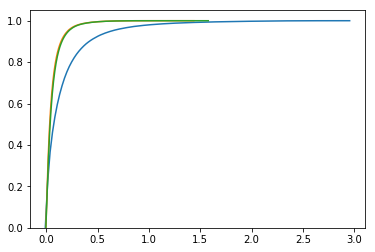

In [11]:
sns.distplot(disMat[0], hist=False, kde_kws=dict(cumulative=True))
sns.distplot(disMat[1], hist=False, kde_kws=dict(cumulative=True))
sns.distplot(disMat[2], hist=False, kde_kws=dict(cumulative=True))

In [ ]:
sns_plot = sns.distplot(disMat[0], hist=False, kde_kws=dict(cumulative=True))
sns_plot = sns.distplot(disMat[1], hist=False, kde_kws=dict(cumulative=True))
sns_plot.savefig("output.png")

In [ ]:
sns.distplot(disMat[0], kde_kws=dict(cumulative=True))

/home/dnguyen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [15]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('../../figs/cdf.pdf')
pyplot.ion()

In [ ]:
sns.distplot(disMat[0], kde_kws=dict(cumulative=True))
pyplot.draw()
pp.savefig()

/home/dnguyen/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


no alignment : 0.004 seconds
 sum sq. error = 1010.1441564836526
cca : 28.508 seconds
 sum sq. error = 454.9137760775018
linear manifold : 54.263 seconds
 sum sq. error = 127.99525660815291
manifold warping : 4216.778 seconds
 sum sq. error = 107.632944402541


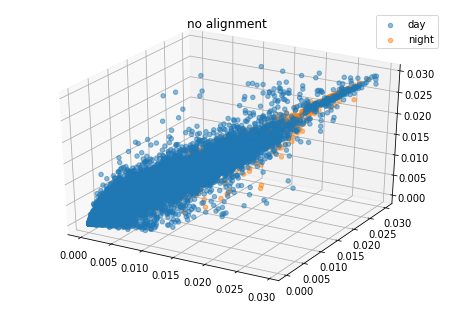

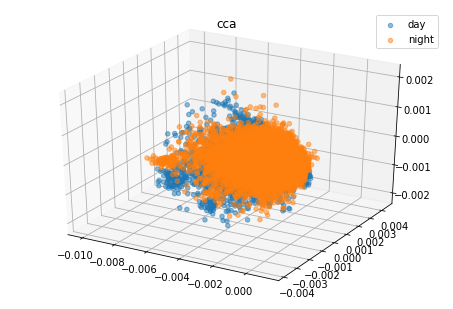

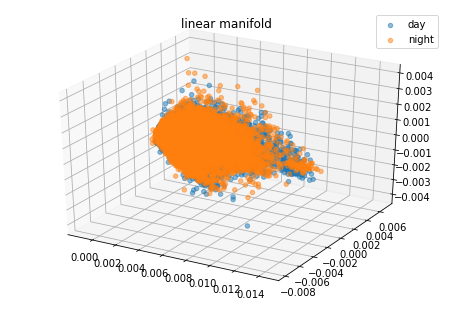

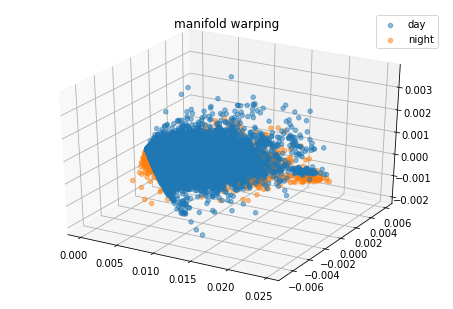

In [8]:
for name, aln in lin_aligners:
    pyplot.figure()
    with Timer(name):
        Xnew, Ynew = aln().project(X_normalized, Y_normalized)
    print (' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew, Ynew, 'day', 'night', name)
    pyplot.draw()

<function matplotlib.pyplot.show>

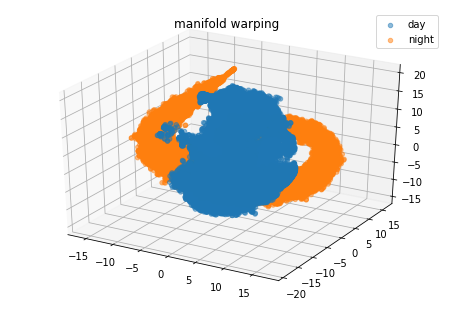

In [23]:
X_embedded = TSNE(n_components=3, perplexity=100).fit_transform(X_normalized)
Y_embedded = TSNE(n_components=3, perplexity=100).fit_transform(Y_normalized)
show_alignment(X_embedded, Y_embedded, 'day', 'night', name)

<function matplotlib.pyplot.show>

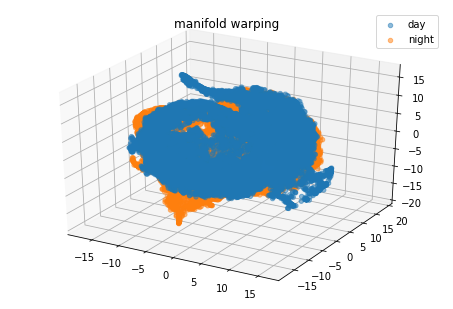

In [25]:
X_embedded_ = TSNE(n_components=3, perplexity=100).fit_transform(Xnew)
Y_embedded_ = TSNE(n_components=3, perplexity=100).fit_transform(Ynew)
show_alignment(X_embedded_, Y_embedded_, 'day', 'night', name)

In [26]:
disMat = np.empty((0,313113025), float)

In [27]:
disMat = np.vstack((disMat, metric.between(Xnew/Xnew.max(), Ynew/Ynew.max()).flatten()))

In [ ]:
disMat3 = disMat
%store disMat3
del disMat3

In [ ]:
x = np.random.randn(200)
y = np.random.randn(100)
sns.distplot(x,
             hist=False,
             kde_kws=dict(cumulative=True))
sns.distplot(y,
             hist=False,
             kde_kws=dict(cumulative=True))

In [10]:
disMat.shape

(3, 313113025)

In [12]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
cca.fit(X_normalized, Y_normalized)
X_c, Y_c = cca.transform(X_normalized, Y_normalized)

In [13]:
pairwise_error(X_c, Y_c, metric=SquaredL2)

193.19418458325868

In [14]:
from alignment import manifold_nonlinear
from warping import manifold_warping_nonlinear, manifold_warping_twostep

In [16]:
other_aligners = (
    ('nonlinear manifold aln', lambda: manifold_nonlinear(X_normalized, Y_normalized, corr, d, Wx, Wy)),
    ('nonlinear manifold warp', lambda: manifold_warping_nonlinear(X_normalized, Y_normalized, d, Wx, Wy)[1:]),
    ('manifold warping two-step', lambda: manifold_warping_twostep(X_normalized, Y_normalized, d, Wx, Wy)[1:]),
)

In [17]:
for name, aln in other_aligners:
    pyplot.figure()
    with Timer(name):
        Xnew, Ynew = aln()
    print (' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew, Ynew, 'day', 'night', name)

/home/dnguyen/ManiNetCluster/inst/python/alignment.py:27: RuntimeWarning: invalid value encountered in true_divide
  vecs[:,i] /= np.linalg.norm(vecs[:,i])


nonlinear manifold aln : 89.559 seconds
 sum sq. error = nan


NameError: name 'show_alignment' is not defined

<Figure size 432x288 with 0 Axes>

In [18]:
Xnew

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])